In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [9]:
import numpy as np
import pandas as pd

dataset = pd.read_csv('tmp/sentiment.csv')

sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

In [10]:
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'

In [11]:
vocab_size = 500
embedding_dim = 16
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            8000      
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 8,109
Trainable params: 8,109
Non-trainable params: 0
_________________________________________________________________


In [14]:
num_epochs = 30
history = model.fit(training_padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final))

Epoch 1/30
50/50 [==============================] - 3s 11ms/step - loss: 0.6931 - accuracy: 0.5066 - val_loss: 0.6944 - val_accuracy: 0.4110
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5223 - val_loss: 0.6952 - val_accuracy: 0.4110
Epoch 3/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5204 - val_loss: 0.6956 - val_accuracy: 0.4110
Epoch 4/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5637 - val_loss: 0.6921 - val_accuracy: 0.5038
Epoch 5/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6868 - accuracy: 0.6541 - val_loss: 0.6848 - val_accuracy: 0.7043
Epoch 6/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6802 - accuracy: 0.7213 - val_loss: 0.6771 - val_accuracy: 0.7293
Epoch 7/30
50/50 [==============================] - 0s 6ms/step - loss: 0.6676 - accuracy: 0.7652 - val_loss: 0.6666 - val_accuracy: 0.7368
Epoch 8/30
50/50 [=

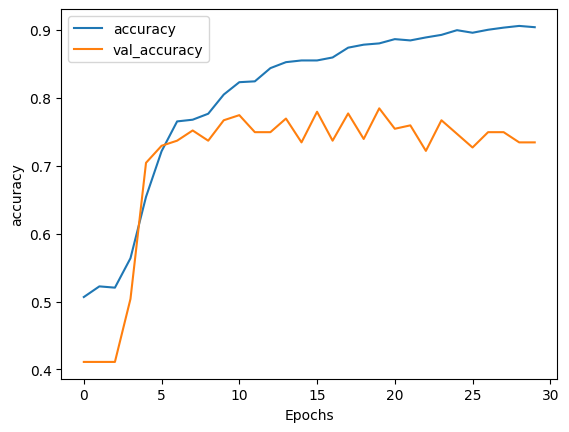

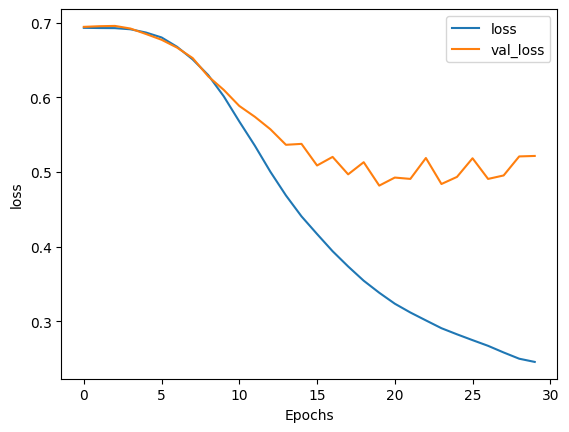

In [15]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [16]:
# First get the weights of the embedding layer
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(500, 16)


In [17]:
import io

# Create the reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Write out the embedding vectors and metadata
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [18]:
# Download the files
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download('vecs.tsv')
    files.download('meta.tsv')

In [19]:
# Use the model to predict a review
fake_reviews = ['I love this phone', 'I hate spaghetti',
                'Everything was cold',
                'Everything was hot exactly as I wanted',
                'Everything was green',
                'the host seated us immediately',
                'they gave us free chocolate cake',
                'not sure about the wilted flowers on the table',
                'only works when I stand on tippy toes',
                'does not work when I stand on my head']

print(fake_reviews)

# Create the sequences
padding_type='post'
sample_sequences = tokenizer.texts_to_sequences(fake_reviews)
fakes_padded = pad_sequences(sample_sequences, padding=padding_type, maxlen=max_length)

print('\nHOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!\n')

classes = model.predict(fakes_padded)

# The closer the class is to 1, the more positive the review is deemed to be
for x in range(len(fake_reviews)):
    print(fake_reviews[x])
    print(classes[x])
    print('\n')

# Try adding reviews of your own
# Add some negative words (such as "not") to the good reviews and see what happens
# For example:
# they gave us free chocolate cake and did not charge us

['I love this phone', 'I hate spaghetti', 'Everything was cold', 'Everything was hot exactly as I wanted', 'Everything was green', 'the host seated us immediately', 'they gave us free chocolate cake', 'not sure about the wilted flowers on the table', 'only works when I stand on tippy toes', 'does not work when I stand on my head']

HOT OFF THE PRESS! HERE ARE SOME NEWLY MINTED, ABSOLUTELY GENUINE REVIEWS!

1/1 [==============================] - 0s 68ms/step
I love this phone
[0.9364903]


I hate spaghetti
[0.16041176]


Everything was cold
[0.64982754]


Everything was hot exactly as I wanted
[0.4728102]


Everything was green
[0.64982754]


the host seated us immediately
[0.6606019]


they gave us free chocolate cake
[0.8955264]


not sure about the wilted flowers on the table
[0.11248594]


only works when I stand on tippy toes
[0.90185994]


does not work when I stand on my head
[0.02415347]


